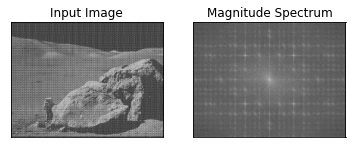

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
 
img = cv.imread('periodic_noise.jpg', cv.IMREAD_GRAYSCALE)
 
dft = cv.dft(np.float32(img),flags = cv.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
 
magnitude_spectrum = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
 
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [2]:
#Filter creating
# Low pass filter
mask = np.zeros((img.shape[0],img.shape[1],2),np.uint8)
centerX, centerY = (int(img.shape[0] / 2),int(img.shape[1] / 2))
mask[centerX-50:centerX+50, centerY - 50:centerY+50,:] = 1

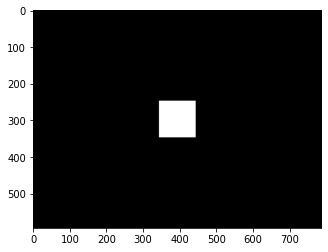

In [3]:
plt.imshow(mask[:,:,0], cmap = 'gray')

In [4]:
# Filtering
dft_shift = dft_shift*mask

C:\Users\Svetlana\AppData\Local\Temp\ipykernel_3864\3830399572.py:1: RuntimeWarning: divide by zero encountered in log
,  filtering_magn_res = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))


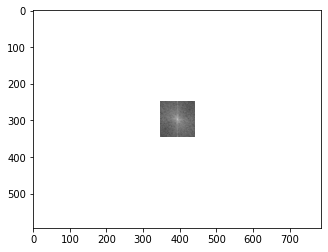

In [7]:
filtering_magn_res = 20*np.log(cv.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
plt.imshow(filtering_magn_res, cmap='gray')

In [ ]:
#fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(dft_shift)
img_back = cv.idft(f_ishift)
img_back = cv.magnitude(img_back[:,:,0],img_back[:,:,1])

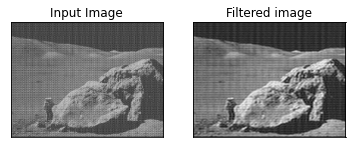

In [17]:
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered image'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
# Реализуйте высокочастотную фильтрацию на основе ядра Гаусса
# Реализуйте удаление периодического шума

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy.ndimage import gaussian_filter

plt.rcParams['figure.figsize'] = [12, 8]

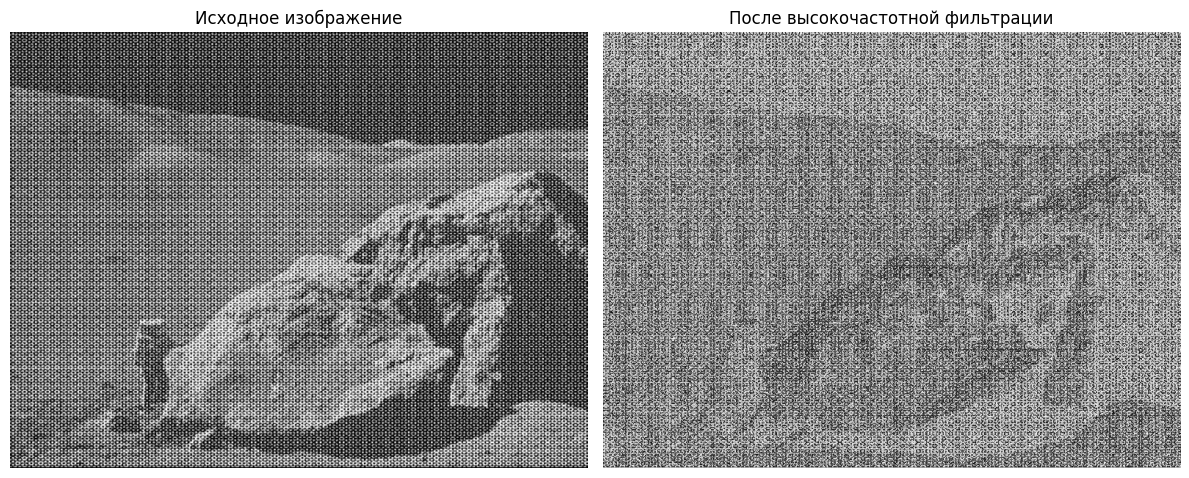

In [8]:
def high_pass_gaussian_filter(image, sigma=3):
    low_freq = gaussian_filter(image, sigma=sigma)
    high_freq = image - low_freq
    high_freq_normalized = cv2.normalize(high_freq, None, 0, 255, cv2.NORM_MINMAX)
    return high_freq_normalized.astype(np.uint8)

def demo_high_pass_filter():
    try:
        image = cv2.imread('periodic_noise.JPG', cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError("Не удалось загрузить изображение")
        
        filtered_image = high_pass_gaussian_filter(image, sigma=3)
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title('Исходное изображение')
        axes[0].axis('off')
        
        axes[1].imshow(filtered_image, cmap='gray')
        axes[1].set_title('После высокочастотной фильтрации')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Ошибка: {e}")
        print("Создаем тестовое изображение...")
        create_test_image()
        
        image = cv2.imread('test_image.jpg', cv2.IMREAD_GRAYSCALE)
        filtered_image = high_pass_gaussian_filter(image, sigma=3)
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        axes[0].imshow(image, cmap='gray')
        axes[0].set_title('Тестовое изображение')
        axes[0].axis('off')
        
        axes[1].imshow(filtered_image, cmap='gray')
        axes[1].set_title('После высокочастотной фильтрации')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

def create_test_image():
    test_image = np.zeros((300, 400), dtype=np.uint8)
    cv2.putText(test_image, 'Test Image', (50, 150), 
                cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 3)
    cv2.rectangle(test_image, (100, 50), (300, 250), 200, 2)
    cv2.imwrite('test_image.jpg', test_image)
    print("Создано тестовое изображение: test_image.jpg")

demo_high_pass_filter()

In [5]:
def remove_periodic_noise(image_path, threshold_ratio=0.3):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Не удалось загрузить изображение: {image_path}")
    
    f_transform = fftpack.fft2(image)
    f_shift = fftpack.fftshift(f_transform)
    
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)
    
    f_filtered = f_shift.copy()
    
    threshold = threshold_ratio * np.max(np.abs(f_shift))
    
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    
    mask = np.ones((rows, cols), dtype=bool)
    
    for i in range(rows):
        for j in range(cols):
            if abs(i - crow) < 20 and abs(j - ccol) < 20:
                continue
            if np.abs(f_shift[i, j]) > threshold:
                mask[i, j] = False
    
    f_filtered[~mask] = 0
    
    f_ishift = fftpack.ifftshift(f_filtered)
    image_filtered = np.real(fftpack.ifft2(f_ishift))
    
    image_filtered = cv2.normalize(image_filtered, None, 0, 255, cv2.NORM_MINMAX)
    
    return image.astype(np.uint8), image_filtered.astype(np.uint8), magnitude_spectrum

def remove_periodic_noise_manual(image_path, noise_coords=None):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Не удалось загрузить изображение: {image_path}")
    
    f_transform = fftpack.fft2(image)
    f_shift = fftpack.fftshift(f_transform)
    
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)
    
    f_filtered = f_shift.copy()
    
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    
    if noise_coords is None:
        threshold = 0.2 * np.max(np.abs(f_shift))
        noise_coords = []
        
        for i in range(rows):
            for j in range(cols):
                if abs(i - crow) < 15 and abs(j - ccol) < 15:
                    continue
                if np.abs(f_shift[i, j]) > threshold:
                    noise_coords.append((i, j))
    
    radius = 5
    for coord in noise_coords:
        i, j = coord
        for x in range(max(0, i-radius), min(rows, i+radius+1)):
            for y in range(max(0, j-radius), min(cols, j+radius+1)):
                if (x - crow)**2 + (y - ccol)**2 > 100:
                    f_filtered[x, y] = 0
    
    f_ishift = fftpack.ifftshift(f_filtered)
    image_filtered = np.real(fftpack.ifft2(f_ishift))
    
    image_filtered = cv2.normalize(image_filtered, None, 0, 255, cv2.NORM_MINMAX)
    
    return image.astype(np.uint8), image_filtered.astype(np.uint8), magnitude_spectrum

In [6]:
def demo_periodic_noise_removal():
    try:
        original, filtered, spectrum = remove_periodic_noise('periodic_noise.JPG')
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        axes[0, 0].imshow(original, cmap='gray')
        axes[0, 0].set_title('Исходное изображение с шумом')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(spectrum, cmap='gray')
        axes[0, 1].set_title('Амплитудный спектр Фурье')
        axes[0, 1].axis('off')
        
        axes[1, 0].imshow(filtered, cmap='gray')
        axes[1, 0].set_title('После удаления шума')
        axes[1, 0].axis('off')
        
        diff = cv2.absdiff(original, filtered)
        axes[1, 1].imshow(diff, cmap='gray')
        axes[1, 1].set_title('Удаленный шум (разность)')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Ошибка при обработке изображения: {e}")
        print("Создаем демонстрационное изображение с периодическим шумом...")
        
        create_test_periodic_noise_image()
        
        original, filtered, spectrum = remove_periodic_noise('test_periodic_noise.jpg')
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        axes[0, 0].imshow(original, cmap='gray')
        axes[0, 0].set_title('Тестовое изображение с шумом')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(spectrum, cmap='gray')
        axes[0, 1].set_title('Амплитудный спектр Фурье')
        axes[0, 1].axis('off')
        
        axes[1, 0].imshow(filtered, cmap='gray')
        axes[1, 0].set_title('После удаления шума')
        axes[1, 0].axis('off')
        
        diff = cv2.absdiff(original, filtered)
        axes[1, 1].imshow(diff, cmap='gray')
        axes[1, 1].set_title('Удаленный шум (разность)')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()

def create_test_periodic_noise_image():
    image = np.zeros((400, 400), dtype=np.uint8)
    
    cv2.rectangle(image, (100, 100), (300, 300), 200, -1)
    cv2.circle(image, (200, 200), 80, 150, -1)
    
    x, y = np.meshgrid(np.arange(400), np.arange(400))
    noise = 50 * np.sin(0.3 * x) * np.sin(0.3 * y) + 30 * np.cos(0.1 * x)
    
    noisy_image = image + noise
    noisy_image = cv2.normalize(noisy_image, None, 0, 255, cv2.NORM_MINMAX)
    
    cv2.imwrite('test_periodic_noise.jpg', noisy_image.astype(np.uint8))
    print("Создано тестовое изображение: test_periodic_noise.jpg")

=== ВЫСОКОЧАСТОТНАЯ ФИЛЬТРАЦИЯ ===


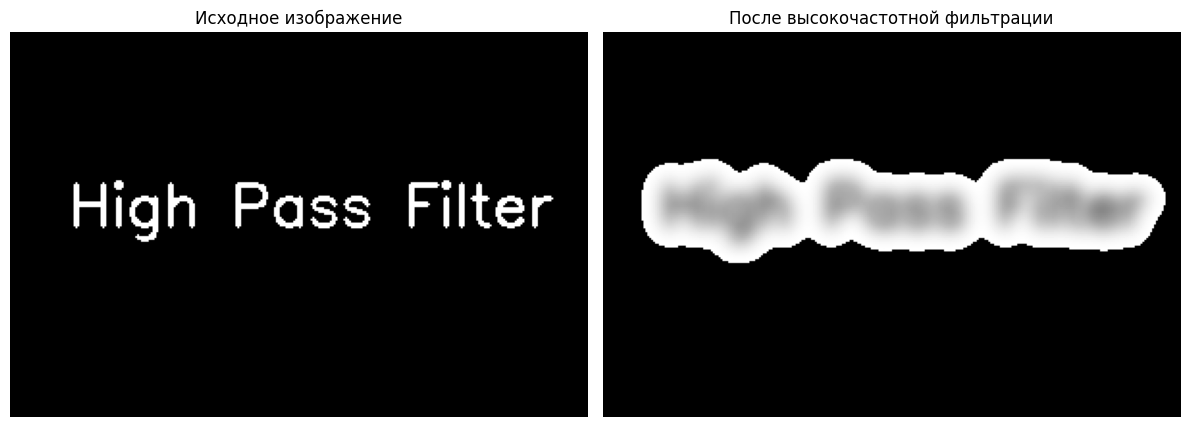


=== УДАЛЕНИЕ ПЕРИОДИЧЕСКОГО ШУМА ===


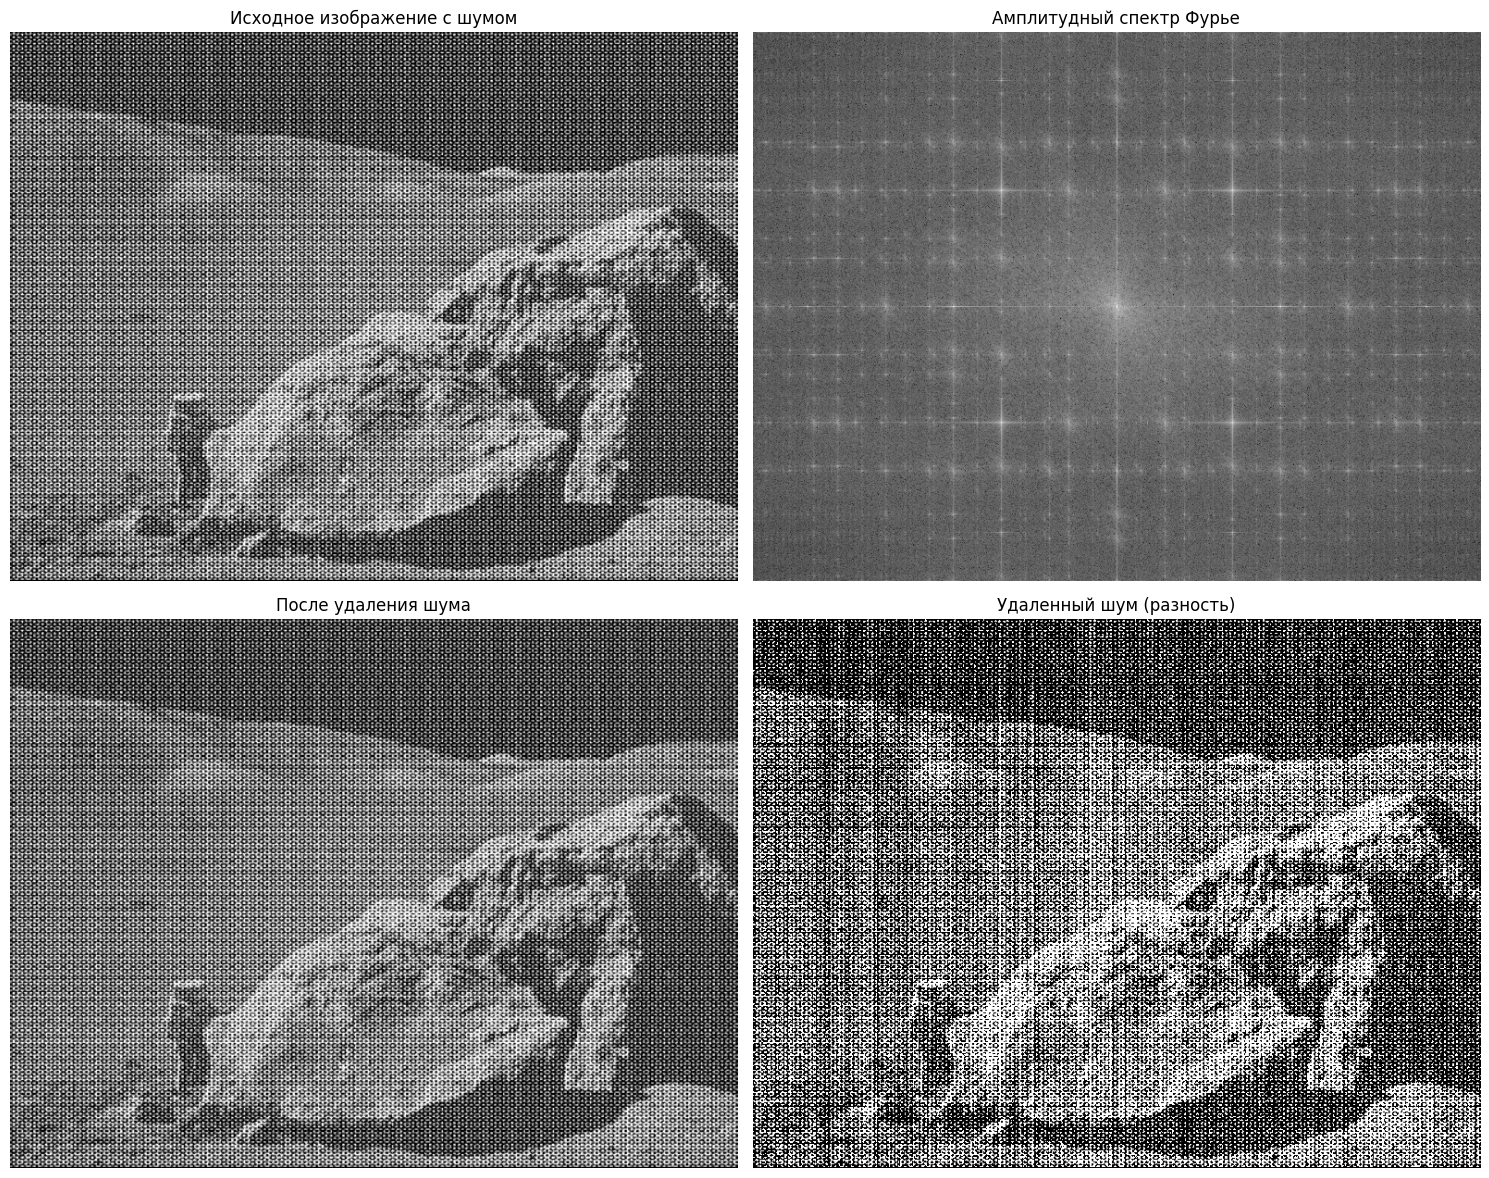

In [7]:
print("=== ВЫСОКОЧАСТОТНАЯ ФИЛЬТРАЦИЯ ===")
demo_high_pass_filter()

print("\n=== УДАЛЕНИЕ ПЕРИОДИЧЕСКОГО ШУМА ===")
demo_periodic_noise_removal()